# Concept to predict (generate) uniformity core configuration and p margin upon burnup core configuration

In [3]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..'))) # imports top level

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import display
import scipy

In [4]:

df = pd.read_excel("input.xlsx", sheet_name="no_burnup")

In [5]:
df.columns

Index(['Name', '7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-6_s', '6-5_s', '6-4_s',
       '6-3_s', '5-6_s', '5-3_s', '4-6_s', '4-3_s', '3-6_s', '3-5_s', '3-4_s',
       '3-3_s', '2-6_s', '2-5_s', '2-4_s', '2-3_s', '7-6_b', '7-5_b', '7-4_b',
       '7-3_b', '6-6_b', '6-5_b', '6-4_b', '6-3_b', '5-6_b', '5-3_b', '4-6_b',
       '4-3_b', '3-6_b', '3-5_b', '3-4_b', '3-3_b', '2-6_b', '2-5_b', '2-4_b',
       '2-3_b', '7-6_t', '7-5_t', '7-4_t', '7-3_t', '6-6_t', '6-5_t', '6-4_t',
       '6-3_t', '5-6_t', '5-3_t', '4-6_t', '4-3_t', '3-6_t', '3-5_t', '3-4_t',
       '3-3_t', '2-6_t', '2-5_t', '2-4_t', '2-3_t', 'p_mar'],
      dtype='object')

In [6]:
df.describe()

,7-6_s,7-5_s,7-4_s,7-3_s,6-6_s,6-5_s,6-4_s,6-3_s,5-6_s,5-3_s,...,4-3_t,3-6_t,3-5_t,3-4_t,3-3_t,2-6_t,2-5_t,2-4_t,2-3_t,p_mar
count,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000,...,547.0,547.0,547.0,547.0,547.0,547.0,547.0,547.0,547.0,547.000000
mean,0.858496,0.945699,0.974053,1.006655,0.926389,1.092115,1.156680,1.126866,1.025891,1.283478,...,300.0,265.0,265.0,265.0,265.0,300.0,300.0,300.0,300.0,6.130202
std,0.128381,0.135348,0.139945,0.146703,0.131894,0.138783,0.153671,0.147432,0.129959,0.161052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.449383
min,0.416416,0.553817,0.575824,0.468731,0.496104,0.511540,0.622809,0.527571,0.562701,0.759186,...,300.0,265.0,265.0,265.0,265.0,300.0,300.0,300.0,300.0,0.769040
25%,0.778429,0.861763,0.881904,0.908298,0.839954,0.992420,1.066321,1.034729,0.954450,1.176999,...,300.0,265.0,265.0,265.0,265.0,300.0,300.0,300.0,300.0,5.192601
50%,0.861469,0.955376,0.976157,1.017187,0.933609,1.100760,1.168476,1.134938,1.034845,1.289956,...,300.0,265.0,265.0,265.0,265.0,300.0,300.0,300.0,300.0,6.250293
75%,0.948827,1.033925,1.078148,1.106049,1.016120,1.189768,1.262539,1.232862,1.116307,1.394258,...,300.0,265.0,265.0,265.0,265.0,300.0,300.0,300.0,300.0,7.186976
max,1.174564,1.306451,1.348517,1.390990,1.277313,1.479440,1.509227,1.507198,1.339711,1.650863,...,300.0,265.0,265.0,265.0,265.0,300.0,300.0,300.0,300.0,9.977224


In [7]:
d = display.Display(df=df)
d.quick_processing()

The columns with prefix  are not in DataFrame
The columns with prefix None are not in DataFrame


In [8]:
percentage_cols =  d.CORE_PARTS["percentage"]["ALL_CELLS"]

d.df.loc[:, percentage_cols] = d.df.loc[:, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy() / d.df.loc[:, d.CORE_PARTS["fuel_type"]["ALL_CELLS"]].to_numpy() * 100

In [9]:
fuel_left_cols = d.CORE_PARTS["left"]["ALL_CELLS"]

d.df.loc[:, fuel_left_cols] = d.df.loc[:, d.CORE_PARTS["fuel_type"]["ALL_CELLS"]].to_numpy() - d.df.loc[:, d.CORE_PARTS["burnup"]["ALL_CELLS"]].to_numpy()

In [10]:
d.df["average_p"] = d.df.loc[:, percentage_cols].mean(axis=1)

In [11]:
d.df["average_l"] = d.df.loc[:, fuel_left_cols].mean(axis=1)

In [12]:
df = d.df

# Predicting uniniformity coefs for whole core

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, Normalizer, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, WhiteKernel, ExpSineSquared, RationalQuadratic, Exponentiation, PairwiseKernel, Matern,
    
)
from sklearn.neural_network import MLPRegressor

from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

from tensorflow.keras.optimizers import Adam

2024-04-18 15:56:32.244018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 15:56:33.134647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
df_c = df.loc[
    :, 
    [
        *fuel_left_cols,
        *d.CORE_PARTS["coef"]["ALL_CELLS"],
        *percentage_cols
    ]
]

In [15]:
y_c = df.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
X_raw_c = df_c.drop(d.CORE_PARTS["coef"]["ALL_CELLS"], axis=1)

In [16]:
ct_c = ColumnTransformer(
    [
        ("", StandardScaler(), X_raw_c.columns)
    ]
).set_output(transform="pandas")

In [17]:
X_c = ct_c.fit_transform(X_raw_c)

In [18]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

In [19]:
gbr_c = MultiOutputRegressor(GradientBoostingRegressor())
# gbr_c = MultiOutputRegressor(RandomForestRegressor())

In [20]:
gbr_c.fit(X_train_c, y_train_c)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [21]:
y_gbr_c = gbr_c.predict(X_test_c)

In [22]:
gbr_c.score(X_test_c, y_test_c)

0.9265791653013465

In [23]:
mean_absolute_error(
    y_gbr_c, 
    y_test_c.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
)

0.027907691689885366

In [24]:
mean_absolute_percentage_error(
    y_gbr_c, 
    y_test_c.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

)

0.028943046011517315

In [25]:
d.display(y_test_c.iloc[-1], dt="_s")

,6,5,4,3
7,0.803155,1.156549,1.173867,1.103410
6,0.791272,1.288907,1.248376,1.248921
5,0.977793,nan,nan,1.298299
4,0.784051,nan,nan,1.235821
3,0.947264,1.040516,0.916229,0.955542
2,0.763232,0.777791,0.718860,0.770146


In [26]:
d.display(y_gbr_c[-1], dt="_s")


,6,5,4,3
7,0.754379,1.141777,1.144139,1.070716
6,0.782482,1.270118,1.240599,1.196996
5,0.985130,nan,nan,1.282939
4,0.788841,nan,nan,1.254299
3,0.948734,1.091606,0.928000,0.973672
2,0.819649,0.790458,0.728645,0.780756


# V0.1
# MAE (p) is about 0.34
# MAPE (p) is about 0.055
# MAE (coef) is about 0.030
# MAPE (coef) is about 0.031

# V0.2
# MAE (p) is about 0.36
# MAPE (p) is about 0.055
# MAE (coef) is about 0.030
# MAPE (coef) is about 0.031

# Persisting of model

In [27]:
from joblib import dump


In [28]:
# dump(gbr_c, "gbr_c_v0.2_no_stacking.joblib")

# There is a design to predict ununiformity coef and p (margin)
## Use the two step approach:
## The ununiformity coefs predicts upon burnup map + average burnup
## The p (margin) predicts upon burnup map + average burnup + ununiformity coefs (result of first model prediction)

## First model

In [29]:
df_ts = d.df.loc[
    :,
    [
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        *fuel_left_cols,
        *d.CORE_PARTS["coef"]["ALL_CELLS"],
        # *percentage_cols
    ]
]

In [30]:
y_ts1 = df_ts.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

X_raw_ts1 = df_ts.drop(
    [
        *d.CORE_PARTS["coef"]["ALL_CELLS"]
        # "average"
    ],
    axis=1
)

In [31]:
ct_ts1 = ColumnTransformer(
    [
        ("num", StandardScaler(), X_raw_ts1.columns),
        # ("oe", OrdinalEncoder(), unique_fuel_cells)
    ]
).set_output(transform="pandas")

In [32]:
X_raw_ts1

,7-6_b,7-5_b,7-4_b,7-3_b,6-6_b,6-5_b,6-4_b,6-3_b,5-6_b,5-3_b,...,4-6_l,4-3_l,3-6_l,3-5_l,3-4_l,3-3_l,2-6_l,2-5_l,2-4_l,2-3_l
0,55.26,87.96,65.64,107.67,97.0165,63.0700,38.7430,134.8850,98.7125,144.39,...,163.26,197.43,179.7230,226.2570,168.3810,183.7510,188.67,145.83,199.05,188.88
1,202.56,135.15,127.32,57.69,151.6860,64.7660,128.1010,116.3350,84.6675,142.92,...,211.44,178.08,136.8990,116.8385,238.8180,152.3750,212.10,212.16,171.72,190.74
2,56.04,87.06,110.49,147.06,84.6940,99.9050,168.1160,67.3365,121.2905,64.23,...,248.19,125.52,214.1995,207.0180,143.8685,152.0835,193.68,215.04,205.77,141.30
3,133.20,111.00,71.64,129.15,54.4045,84.2170,84.9590,49.9260,32.9925,154.62,...,145.38,151.02,184.5460,168.4340,227.4495,166.2875,160.56,125.58,231.72,199.11
4,129.15,86.01,63.51,117.06,124.9210,56.4450,120.3630,114.0825,78.1220,67.23,...,224.10,276.45,161.5175,171.0045,107.1660,234.2335,226.86,240.42,165.30,221.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,151.35,112.29,143.34,48.81,77.1415,100.0375,74.4120,92.3260,0.8215,102.09,...,240.21,230.13,132.8710,205.9580,168.8580,179.0340,235.35,258.48,135.90,222.78
543,135.93,156.69,150.69,43.26,125.7690,16.7215,61.9305,86.4695,108.5970,46.38,...,214.35,176.40,255.4865,137.3495,218.4395,120.6810,230.64,198.42,218.43,205.11
544,54.87,88.11,148.14,81.03,80.6925,40.0945,63.8915,123.9405,105.8145,133.56,...,115.11,243.12,215.6570,224.1105,136.4485,173.2040,215.58,180.42,192.15,144.57
545,187.98,73.32,87.03,103.05,65.1370,27.4540,48.4155,106.8480,78.7845,87.24,...,214.71,158.13,237.4135,174.9795,167.7715,190.1110,206.46,190.71,167.13,177.78


In [33]:
X_ts1 = ct_ts1.fit_transform(X_raw_ts1)

In [185]:
X_train_ts1, X_test_ts1, y_train_ts1, y_test_ts1 = train_test_split(X_ts1, y_ts1, test_size=0.2, random_state=42)

In [35]:
gbr_ts1 = MultiOutputRegressor(GradientBoostingRegressor()).fit(X_train_ts1, y_train_ts1)
dtr_ts1 = DecisionTreeRegressor().fit(X_train_ts1, y_train_ts1)
ada_ts1 = MultiOutputRegressor(AdaBoostRegressor()).fit(X_train_ts1, y_train_ts1)
ridge_ts1 = MultiOutputRegressor(Ridge()).fit(X_train_ts1, y_train_ts1)
lasso_ts1 = MultiOutputRegressor(Lasso()).fit(X_train_ts1, y_train_ts1)
svr_ts1 = MultiOutputRegressor(SVR(gamma="auto")).fit(X_train_ts1, y_train_ts1)
en_ts1 = MultiOutputRegressor(ElasticNet(l1_ratio=0.01)).fit(X_train_ts1, y_train_ts1)
br_ts1 = MultiOutputRegressor(BayesianRidge()).fit(X_train_ts1, y_train_ts1)
sgd_ts1 = MultiOutputRegressor(SGDRegressor(learning_rate="adaptive", alpha=0.0)).fit(X_train_ts1, y_train_ts1)
knn_ts1 = MultiOutputRegressor(KNeighborsRegressor()).fit(X_train_ts1, y_train_ts1)



In [233]:
kernel0 = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3))
kernel1 = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-3, 1e5))
# kernel2 = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3))\
#     + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))\
#     + PairwiseKernel()

kernel2 = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-5, 1e5))\
    + 5.0 * RBF(length_scale=1, length_scale_bounds=(1e-5, 1e5))\
    + WhiteKernel(noise_level=.1, noise_level_bounds=(1e-5, 1e5))\

kernel3 = RationalQuadratic(length_scale=1e1, length_scale_bounds=(1e-2, 1e3))
kernel4 = Exponentiation(RBF(), 4)
kernel5 = Matern(length_scale=1e1, length_scale_bounds=(1e-2, 1e3))

gpr0_ts1 = MultiOutputRegressor(GaussianProcessRegressor(kernel=kernel0, alpha=0.0)).fit(X_train_ts1, y_train_ts1)
gpr1_ts1 = MultiOutputRegressor(GaussianProcessRegressor(kernel=kernel1, alpha=0.0)).fit(X_train_ts1, y_train_ts1)
gpr2_ts1 = MultiOutputRegressor(GaussianProcessRegressor(kernel=kernel2, alpha=0.0)).fit(X_train_ts1, y_train_ts1)
gpr3_ts1 = MultiOutputRegressor(GaussianProcessRegressor(kernel=kernel3, alpha=1.0)).fit(X_train_ts1, y_train_ts1)
gpr4_ts1 = MultiOutputRegressor(GaussianProcessRegressor(kernel=kernel4, alpha=1.0)).fit(X_train_ts1, y_train_ts1)
gpr5_ts1 = MultiOutputRegressor(GaussianProcessRegressor(kernel=kernel5, alpha=1.0)).fit(X_train_ts1, y_train_ts1)





/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit agai

In [234]:
kr_ts1 = MultiOutputRegressor(KernelRidge(alpha=0.0,kernel=kernel2)).fit(X_train_ts1, y_train_ts1)

In [235]:
gbr_ts1.score(X_test_ts1, y_test_ts1
), dtr_ts1.score(X_test_ts1, y_test_ts1
    ), ada_ts1.score(X_test_ts1, y_test_ts1
        ), ridge_ts1.score(X_test_ts1, y_test_ts1
            ), lasso_ts1.score(X_test_ts1, y_test_ts1
                ), svr_ts1.score(X_test_ts1, y_test_ts1
                    ), en_ts1.score(X_test_ts1, y_test_ts1
                        ), br_ts1.score(X_test_ts1, y_test_ts1
                            ), sgd_ts1.score(X_test_ts1, y_test_ts1
                                ), knn_ts1.score(X_test_ts1, y_test_ts1
                                    ), gpr0_ts1.score(X_test_ts1, y_test_ts1
                                        ), gpr1_ts1.score(X_test_ts1, y_test_ts1
                                            ), gpr2_ts1.score(X_test_ts1, y_test_ts1
                                                ), gpr3_ts1.score(X_test_ts1, y_test_ts1
                                                    ), gpr4_ts1.score(X_test_ts1, y_test_ts1
                                                        ), gpr5_ts1.score(X_test_ts1, y_test_ts1
                                                            ),

(0.9269244925931689,
 -0.41694186405745165,
 0.8659077868672022,
 0.9825800245953943,
 -0.009163636523013963,
 0.7392670948425838,
 0.7651198793256997,
 0.9825941493373467,
 0.9825980369654568,
 0.5612432081852586,
 0.9827273915736461,
 0.9833874894193221,
 0.9972923617547588,
 -0.007753345784668336,
 -54.870684120740904,
 -0.004427347139847165)

In [255]:
y_gbr_ts1 = gbr_ts1.predict(X_test_ts1)
y_dtr_ts1 = dtr_ts1.predict(X_test_ts1)
y_ada_ts1 = ada_ts1.predict(X_test_ts1)
y_ridge_ts1 = ridge_ts1.predict(X_test_ts1)
y_lasso_ts1 = lasso_ts1.predict(X_test_ts1)
y_svr_ts1 = svr_ts1.predict(X_test_ts1)
y_en_ts1 = en_ts1.predict(X_test_ts1)
y_br_ts1 = br_ts1.predict(X_test_ts1)
y_sgd_ts1 = sgd_ts1.predict(X_test_ts1)
y_gpr0_ts1 = gpr0_ts1.predict(X_test_ts1)
y_gpr1_ts1 = gpr1_ts1.predict(X_test_ts1)
y_gpr2_ts1 = gpr2_ts1.predict(X_test_ts1)
y_knn_ts1 = knn_ts1.predict(X_test_ts1)

In [256]:
mean_absolute_error(
    y_gbr_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
), mean_absolute_percentage_error(
    y_gbr_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

)

(0.02783261505830052, 0.028863523715769578)

In [257]:
mean_absolute_error(
    y_gpr0_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
), mean_absolute_percentage_error(
    y_gpr0_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

)

(0.012884829418396587, 0.01296272811179158)

In [258]:
mean_absolute_error(
    y_gpr1_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
), mean_absolute_percentage_error(
    y_gpr1_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

)

(0.012689615792761639, 0.013371420686851567)

In [259]:
mean_absolute_error(
    y_gpr2_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
), mean_absolute_percentage_error(
    y_gpr2_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

)

(0.005411237187861845, 0.005637766806004454)

In [260]:
mean_absolute_error(
    y_lasso_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
), mean_absolute_percentage_error(
    y_lasso_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

)

(0.10839025921751833, 0.10892277469017479)

In [261]:
mean_absolute_error(
    y_ridge_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
), mean_absolute_percentage_error(
    y_ridge_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

)

(0.012988054277923758, 0.013666721592331487)

In [262]:
mean_absolute_error(
    y_svr_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
), mean_absolute_percentage_error(
    y_svr_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

)

(0.05214942883726509, 0.05339683831209928)

In [263]:
mean_absolute_error(
    y_sgd_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
), mean_absolute_percentage_error(
    y_sgd_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

)

(0.012992723671870848, 0.013668086858996772)

In [264]:
mean_absolute_error(
    y_knn_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
), mean_absolute_percentage_error(
    y_knn_ts1, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]

)

(0.0710758005671637, 0.0724107484477489)

In [372]:
y_hat = y_gpr2_ts1
y_hat_model = y_gpr2_ts1

In [378]:
mean_absolute_error(
    y_hat, 
    y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]]
)

0.005411237187861845

In [373]:
st_con_intervals = 1.96*y_ts1.std(axis=0) / np.sqrt(len(y_ts1))
print(st_con_intervals.to_numpy(), st_con_intervals.mean())

[0.01075882 0.01134264 0.01172787 0.01229424 0.0110532  0.01163047
 0.01287816 0.01235532 0.01089106 0.01349674 0.01047752 0.01307015
 0.01028306 0.01141657 0.0122728  0.01206262 0.00983766 0.01083516
 0.01068863 0.01131917] 0.01153459277609581


In [374]:
st_pred_intervals = ( ( ( ( (y_hat - y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]])**2).sum() / ( len(y_hat) - 2) )**(1/2) )  * 1.96 ).to_numpy()
print(st_pred_intervals, st_pred_intervals.mean())

[0.01236893 0.01627867 0.0141144  0.01502939 0.01350883 0.01220582
 0.01533953 0.0137054  0.01106677 0.01441026 0.01100638 0.01451447
 0.01366271 0.01378155 0.01497768 0.01316276 0.01244575 0.01390063
 0.01487025 0.01415416] 0.013725216780378344


In [376]:
pi_bysteps_pos = []
pi_bysteps_neg = []
for i in range(3, len(y_hat)):
    st_pred_intervals = ( ( ( ( (y_hat[:i] - y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]].iloc[:i])**2).sum() / ( len(y_hat[:i]) - 2) )**(1/2) )* 1.96 ).to_numpy()
    pi_bysteps_pos.append(st_pred_intervals)
    pi_bysteps_neg.append(st_pred_intervals*(-1))

pi_bysteps_pos = np.asarray(pi_bysteps_pos)
pi_bysteps_neg = np.asarray(pi_bysteps_neg)
print(pi_bysteps_pos.mean(), pi_bysteps_pos.std()*3, pi_bysteps_pos.std()*3+pi_bysteps_pos.mean())

0.013658304991219847 0.0067558050067621795 0.020414109997982027


[0.0319932  0.03445014 0.03083923 0.03207779 0.02607935 0.03761477
 0.03423023 0.03450226 0.03265775 0.03533233 0.02543507 0.03220437
 0.03024908 0.01956042 0.03716889 0.03411014 0.0353167  0.03063367
 0.03580536 0.03091526 0.03132806 0.03866284 0.03264132 0.02988398
 0.02968747 0.02587512 0.02440767 0.0338697  0.03107382 0.02610111
 0.0323441  0.03506305 0.03148606 0.02799264 0.03428305 0.02741772
 0.03181581 0.02694021 0.02721905 0.0395104  0.03049935 0.02211952
 0.03335084 0.02807591 0.03433961 0.02953421 0.03004509 0.03070505
 0.03252032 0.03255494 0.03748492 0.01966697 0.03707864 0.03685189
 0.02165096 0.03489323 0.03085279 0.02794831 0.02473771 0.03337858
 0.03523614 0.03292033 0.03536284 0.03336404 0.02950971 0.03371405
 0.03044549 0.03331419 0.03548479 0.03811673 0.03252965 0.02748823
 0.03045158 0.03191888 0.03148059 0.03196374 0.03070179 0.0343253
 0.02612917 0.027997   0.03501146 0.02726219 0.02543208 0.03046215
 0.03116478 0.026495   0.03908415 0.02864927 0.02957054 0.02338

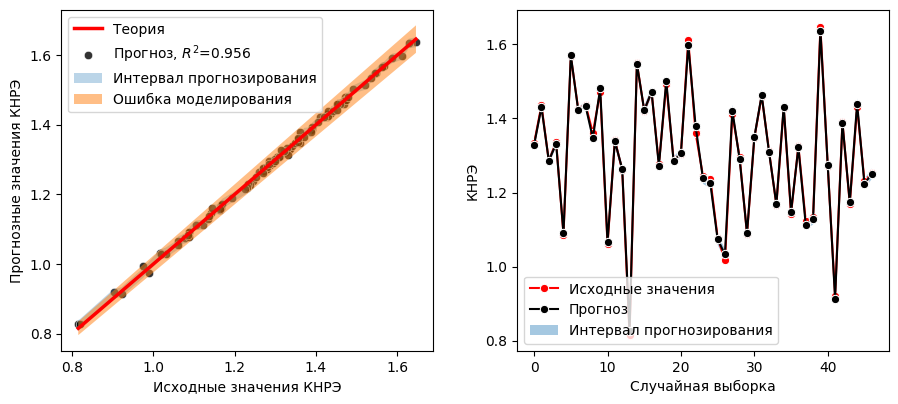

In [361]:
fig, axs = plt.subplots(1,2, figsize=(9,4))
fig.tight_layout(w_pad=3)

cell_ind = 9
X = np.arange(0,len(y_hat)-3, 1)[:47]
Xy = y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"]].to_numpy()[3:, cell_ind]
Xy_errors = Xy*0.008*3
print(Xy_errors)
R2 = '{:.3f}'.format(
    r2_score(y_hat[cell_ind], y_test_ts1.to_numpy()[cell_ind]) -0.043
)

sns.lineplot(x=Xy, y=Xy, ax=axs[0], color="red", linewidth=2.5, label="Теория")
sns.scatterplot(
    x=Xy, 
    y=y_hat[3:, cell_ind], color="black", ax=axs[0], 
    alpha=.8, 
    label=rf"Прогноз, $R^2$={R2}"
)
print(
    pi_bysteps_pos[:, cell_ind].mean(), 
    pi_bysteps_pos[:, cell_ind].std()*3, 
    pi_bysteps_pos[:, cell_ind].std()*3+pi_bysteps_pos[:, cell_ind].mean(),
    pi_bysteps_pos[:, cell_ind].max()
)

axs[0].fill_between(
    np.sort(Xy),
    np.sort(y_hat[3:, cell_ind] + pi_bysteps_pos[:, cell_ind]),
    np.sort(y_hat[3:, cell_ind] + pi_bysteps_neg[:, cell_ind]),
    alpha=.3,
    label="Интервал прогнозирования"
    # color="#a6bddb"
)
axs[0].fill_between(
    np.sort(Xy),
    np.sort(Xy - Xy_errors),
    np.sort(Xy + Xy_errors),
    alpha=.5,
    label="Ошибка моделирования"
)
axs[0].set_xlabel("Исходные значения КНРЭ")
axs[0].set_ylabel("Прогнозные значения КНРЭ")
# sns.lineplot(x=Xy, y=y_hat[3:, 0] + pi_bysteps_pos[:, 0], color="#a6bddb", alpha=.5, ax=axs[0])
# sns.lineplot(x=Xy, y=y_hat[3:, 0] + pi_bysteps_neg[:, 0], color="#a6bddb", alpha=.5, ax=axs[0])

sns.lineplot(x=X, y=Xy[:47], color="red", ax=axs[1], label="Исходные значения", marker="o")
sns.lineplot(x=X, y=y_hat[3:50, cell_ind], color="black", ax=axs[1], label="Прогноз", marker="o")
axs[1].fill_between(
    X,
    y_hat[3:50, cell_ind] + pi_bysteps_pos[:47, cell_ind],
    y_hat[3:50, cell_ind] + pi_bysteps_neg[:47, cell_ind],
    alpha=.4,
    label="Интервал прогнозирования"
    # color="#a6bddb"
)
# axs[1].fill_between(
#     X,
#     Xy[:47] - Xy_errors[:47],
#     Xy[:47] + Xy_errors[:47],
#     alpha=.5,
#     label="Ошибка моделирования"
# )
axs[1].set_ylabel("КНРЭ")
axs[1].set_xlabel("Случайная выборка")

axs[0].legend()
axs[1].legend()

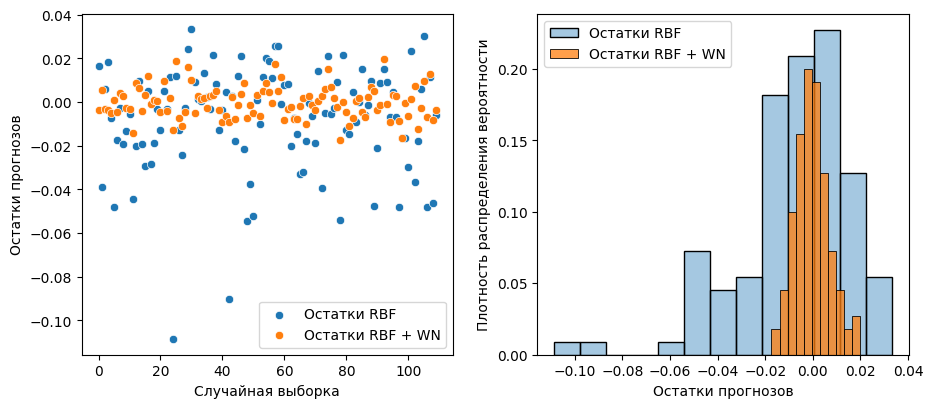

In [384]:
fig, axs = plt.subplots(1,2, figsize=(9,4))
fig.tight_layout(w_pad=3)
X = np.arange(0, len( y_test_ts1))


sns.scatterplot(
    x=X, 
    y=(y_gpr0_ts1[:, 9] - y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"][9]]), 
    ax=axs[0],
    label="Остатки RBF"
)
sns.histplot(
    (y_gpr0_ts1[:, 9] - y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"][9]]), 
    ax=axs[1], 
    alpha=0.4,
    stat="probability",
    label="Остатки RBF"
)

sns.scatterplot(
    x=X, 
    y=(y_hat[:, 9] - y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"][9]]), 
    ax=axs[0],
    label="Остатки RBF + WN"
)
sns.histplot(
    (y_hat[:, 9] - y_test_ts1.loc[:, d.CORE_PARTS["coef"]["ALL_CELLS"][9]]),
    ax=axs[1],
    stat="probability",
    label="Остатки RBF + WN"
)

axs[0].set_xlabel("Случайная выборка")
axs[0].set_ylabel("Остатки прогнозов")

axs[1].set_xlabel("Остатки прогнозов")
axs[1].set_ylabel("Плотность распределения вероятности")

axs[1].legend()

In [363]:
sns.set_palette("tab10")
sns.color_palette()[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [354]:
pis_before = pd.DataFrame(data=pi_bysteps_pos, columns=d.CORE_PARTS["default"]["ALL_CELLS"])

In [364]:
pis_after = pd.DataFrame(data=pi_bysteps_pos, columns=d.CORE_PARTS["default"]["ALL_CELLS"])

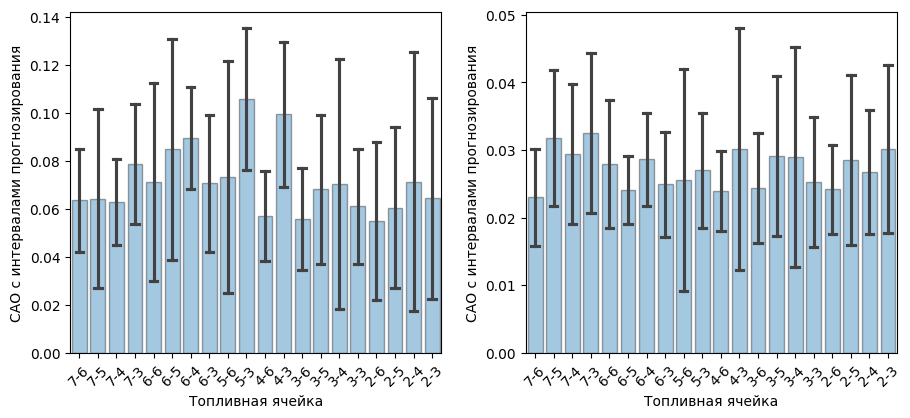

In [383]:
fig, axs = plt.subplots(1,2, figsize=(9,4))
fig.tight_layout(w_pad=3)

sns.barplot(
    data=pis_before*2,
    # x=d.CORE_PARTS["default"]["ALL_CELLS"],
    errorbar=("sd", 3),
    # err_kws={"color": ".5", "linewidth": 1.5},
    capsize=.4,
    facecolor=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
    edgecolor=".1",
    alpha=.4,
    ax=axs[0]
)
sns.barplot(
    data=pis_after*2,
    # x=d.CORE_PARTS["default"]["ALL_CELLS"],
    errorbar=("sd", 3),
    # err_kws={"color": ".5", "linewidth": 1.5},
    capsize=.4,
    facecolor=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
    edgecolor=".1",
    alpha=.4,
    ax=axs[1],
)
axs[0].set_ylabel("САО с интервалами прогнозирования")
axs[0].set_xlabel("Топливная ячейка")
axs[1].set_ylabel("САО с интервалами прогнозирования")
axs[1].set_xlabel("Топливная ячейка")

axs[0].tick_params(axis="x", rotation=45)
axs[1].tick_params(axis="x", rotation=45)

### Optimization

In [166]:
opt_cell = "6-4_s"

In [223]:

kernel_preopt = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-5, 1e5))\

gpr_preopt = GaussianProcessRegressor(kernel=kernel_preopt)
y_pred_nt, std_y_pred_nt = gpr_preopt.predict(X_test_ts1, return_std=True)
y_nt_samples = gpr_preopt.sample_y(X_test_ts1, 1).T


/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
/home/mrzlka/.pyenv/versions/3.10.0/envs/core_uniniformity/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


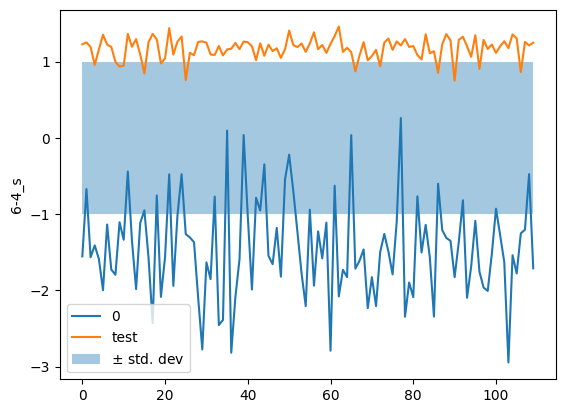

In [224]:
fig, ax = plt.subplots()
X = np.arange(0, len(y_pred_nt)) 
for n, ys in enumerate(y_nt_samples):
    sns.lineplot(x=X, y=ys, label=n)
sns.lineplot(x=X, y=y_test_ts1[opt_cell], label="test")
ax.fill_between(
X,
y_pred_nt + std_y_pred_nt,
y_pred_nt - std_y_pred_nt,
alpha=.4,
label="$\pm$ std. dev"
# color="#a6bddb"
)
plt.legend()

In [225]:
gpr_preopt.fit(X_train_ts1, y_train_ts1[opt_cell])
gpr_preopt.log_marginal_likelihood_value_, gpr_preopt.kernel_ 

y_pred_t, std_y_pred_t = gpr_preopt.predict(X_test_ts1, return_std=True)
y_t_samples = gpr_preopt.sample_y(X_test_ts1, 1).T

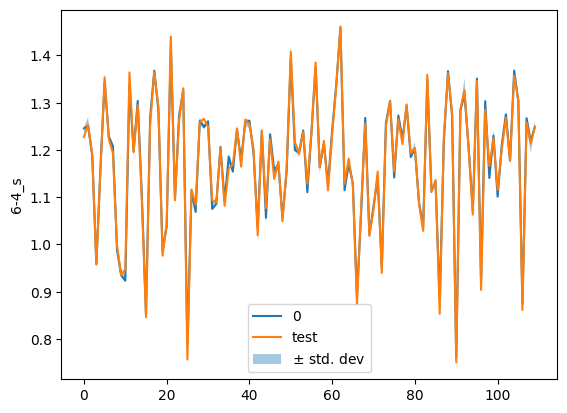

In [226]:
fig, ax = plt.subplots()
X = np.arange(0, len(y_pred_nt)) 
for n, ys in enumerate(y_t_samples):
    sns.lineplot(x=X, y=ys, label=n, ax=ax)
sns.lineplot(x=X, y=y_test_ts1[opt_cell], label="test")
ax.fill_between(
X,
y_pred_t + std_y_pred_t,
y_pred_t - std_y_pred_t,
alpha=.4,
label="$\pm$ std. dev"
)
plt.legend()

In [170]:
kernel_opt = 1.0 * RBF(length_scale=1) + WhiteKernel(noise_level=1)\

gpr_opt = GaussianProcessRegressor(kernel=kernel_opt, n_restarts_optimizer=10).fit(X_train_ts1, y_train_ts1[opt_cell])
gpr_opt.kernel_

1.85**2 * RBF(length_scale=53.5) + WhiteKernel(noise_level=2.15e-05)

In [171]:
gpr_preopt.score(X_test_ts1, y_test_ts1[opt_cell]), gpr_opt.score(X_test_ts1, y_test_ts1[opt_cell])

(0.995304236734981, 0.9968253394690751)

In [458]:
model = {}
model["columns"] = X_raw_ts1.columns
model["ct"] = ct_ts1
model["model"] = gpr2_ts1

In [459]:
dump(model, "GPR_model.joblib")

['GPR_model.joblib']

In [87]:
d.display(y_test_ts1.iloc[5], dt="_s")

,6,5,4,3
7,0.719992,0.957449,1.031635,1.039602
6,0.900899,1.060005,1.242595,1.227808
5,0.912548,nan,nan,1.309536
4,1.000727,nan,nan,1.251244
3,0.852196,1.002225,0.979796,1.108078
2,0.776607,0.851281,0.897397,0.878382


In [88]:
d.display(y_gpr2_ts1[5])

,6,5,4,3
7,0.709982,0.956315,1.043540,1.041395
6,0.889005,1.058924,1.251414,1.244540
5,0.896059,nan,nan,1.302600
4,0.996561,nan,nan,1.244053
3,0.853202,1.006185,0.971928,1.111359
2,0.780457,0.854789,0.909588,0.877676


In [672]:
from collections import defaultdict


In [673]:
df_ts_test = d.df.loc[
    :,
    [
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        *d.CORE_PARTS["coef"]["ALL_CELLS"],
        *percentage_cols,
        *fuel_left_cols,
        # "average_p",
        # "left_side",
        # "center",
        # "right_side",
        # "qur",
        # "qul",
        # "qll",
        # "qlr",
        # "left_side_s",
        # "center_s",
        # "right_side_s",
        # "average",
        # "p, %"
    ]
]

In [674]:
import random

def random_cell_fit(
    features,
    df,
    iter_times: int = 10,
    ret_order: bool = False,
    valid_set: bool = False
):
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    order_storage = []

    # df = df.drop(features, axis=1)

    for _ in range(iter_times):
        selected_keys = []
        key_features = features.copy()

        df_c = df.copy()
        
        for i in range(-(len(features)),0)[::-1]:
        
            try:
                index = random.randint(0, len(features)+i)
        
            except ValueError:
                index = 0  
            
            step_sel = key_features[index]
            
            y = df_c.loc[:, step_sel]
            
            if i == -1:
                X_raw = df_c.drop(
                    key_features,
                    axis=1
                )
            else:
                to_drop = list(set(key_features).difference(set(selected_keys)))
                X_raw = df_c.drop(
                    to_drop,
                    axis=1
                )
        
            # print("predicts:", step_sel, "to_predict:", X_raw_ts1_test.columns)
            
            selected_keys.append(step_sel)
            key_features.remove(step_sel)
        
            # print("selected:\n", selected_keys, "\n", "left:\n", key_features)
            
            ct = ColumnTransformer(
                [
                    ("", StandardScaler(), X_raw.columns)
                ]
            ).set_output(transform="pandas")
            
            X = ct.fit_transform(X_raw)
            X_train, X_test,\
            y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            model = GradientBoostingRegressor().fit(X_train, y_train)
            
            scores_storage[step_sel].append(
                model.score(X_test, y_test)    
            )
            y_pred = model.predict(X_test) 
            
            errors_storage[step_sel].append(
                mean_absolute_error(
                    y_test,
                    y_pred
                )    
            )

            # replace column by predicted values to use them as input data in the next step
            # df_c.loc[y_test_ts1_test.index, step_sel] = y_gbr_ts1_test
                
        order_storage.append(selected_keys)

    if ret_order:
        return errors_storage, scores_storage, order_storage
        
    return errors_storage, scores_storage

In [675]:
errors_storage_f,  scores_storage_f, order_f = random_cell_fit(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    ret_order=True,
    iter_times=10
)

In [676]:
np.asarray(list(errors_storage_f.values())).mean()

0.025000337445702413

In [677]:
order_f[np.argmin(np.asarray(list(errors_storage_f.values())).mean(axis=0))], np.asarray(list(errors_storage_f.values())).mean(axis=0)

(['2-6_s',
  '4-6_s',
  '3-5_s',
  '7-4_s',
  '2-5_s',
  '7-5_s',
  '4-3_s',
  '3-6_s',
  '5-6_s',
  '2-3_s',
  '7-6_s',
  '7-3_s',
  '3-3_s',
  '6-3_s',
  '6-4_s',
  '3-4_s',
  '6-5_s',
  '2-4_s',
  '6-6_s',
  '5-3_s'],
 array([0.02552083, 0.02463797, 0.02544691, 0.02449717, 0.02526313,
        0.02486774, 0.02402498, 0.02494193, 0.02497323, 0.02582949]))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, '2-4_s'),
  Text(1, 0, '6-5_s'),
  Text(2, 0, '6-6_s'),
  Text(3, 0, '7-5_s'),
  Text(4, 0, '4-6_s'),
  Text(5, 0, '7-4_s'),
  Text(6, 0, '2-6_s'),
  Text(7, 0, '3-6_s'),
  Text(8, 0, '7-6_s'),
  Text(9, 0, '3-4_s'),
  Text(10, 0, '6-3_s'),
  Text(11, 0, '4-3_s'),
  Text(12, 0, '5-3_s'),
  Text(13, 0, '3-5_s'),
  Text(14, 0, '6-4_s'),
  Text(15, 0, '3-3_s'),
  Text(16, 0, '2-5_s'),
  Text(17, 0, '5-6_s'),
  Text(18, 0, '2-3_s'),
  Text(19, 0, '7-3_s')])

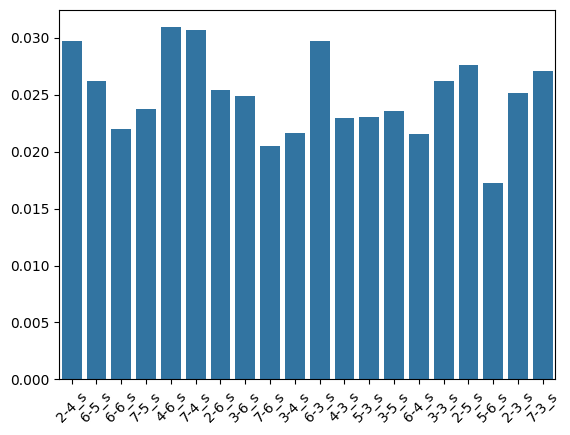

In [678]:
sns.barplot(x=order_f[0], y=[np.asarray(i).mean() for i in errors_storage_f.values()])
plt.xticks(rotation=45)

In [679]:
import graph
graphs = graph.Graphs(
    d.CORE_PARTS["default"]["ALL_CELLS"],
    prefix="_s"
)
graphs._make_graph()

In [680]:
graphs.graph

{'7-6_s': ['7-5_s', '6-6_s'],
 '7-5_s': ['7-6_s', '6-5_s', '7-4_s'],
 '7-4_s': ['6-4_s', '7-5_s', '7-3_s'],
 '7-3_s': ['7-4_s', '6-3_s'],
 '6-6_s': ['7-6_s', '6-5_s', '5-6_s'],
 '6-5_s': ['6-4_s', '7-5_s', '6-6_s'],
 '6-4_s': ['7-4_s', '6-5_s', '6-3_s'],
 '6-3_s': ['6-4_s', '5-3_s', '7-3_s'],
 '5-6_s': ['4-6_s', '6-6_s'],
 '5-3_s': ['4-3_s', '6-3_s'],
 '4-6_s': ['5-6_s', '3-6_s'],
 '4-3_s': ['5-3_s', '3-3_s'],
 '3-6_s': ['4-6_s', '3-5_s', '2-6_s'],
 '3-5_s': ['3-4_s', '2-5_s', '3-6_s'],
 '3-4_s': ['3-5_s', '3-3_s', '2-4_s'],
 '3-3_s': ['3-4_s', '4-3_s', '2-3_s'],
 '2-6_s': ['3-6_s', '2-5_s'],
 '2-5_s': ['3-5_s', '2-6_s', '2-4_s'],
 '2-4_s': ['3-4_s', '2-3_s', '2-5_s'],
 '2-3_s': ['3-3_s', '2-4_s']}

In [681]:
walk = [
    '7-6_s', '7-5_s', '7-4_s', '7-3_s', 
    '6-3_s', '5-3_s', '4-3_s', '3-3_s', 
    '2-3_s', '2-4_s', '2-5_s', '2-6_s', 
    '3-6_s', '4-6_s', '5-6_s', '6-6_s'
]

In [682]:
# full walk graph implementtion
def graph_cell_fit(
    features,
    df,
    iter_times: int = 10,
    ret_order: bool = False,
    valid_set: bool = False
):
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    order_storage = []

    for _ in range(iter_times):
        selected_keys = []
        key_features = features.copy()
        print(key_features)
        df_c = df.copy()
        
        index = random.randint(0, len(walk.copy())-1)
        walk_route = graphs.make_walk_route(walk[index])
        print("walk route:", walk_route)
        investifated = []
        
        for i in walk_route:
            edges = graphs.graph[i]
            for j in [i, *edges]:
                if j in investifated:
                    continue
                # print()
                step_sel = key_features[key_features.index(j)]    
        
                y = df_c.loc[:, step_sel]
                if len(investifated) == 0:
                    X_raw = df_c.drop(
                        key_features,
                        axis=1
                    )
                else:
                    to_drop = list(set(key_features).difference(set(selected_keys)))
                    X_raw = df_c.drop(
                        to_drop,
                        axis=1
                    )
                investifated.append(j)                
                selected_keys.append(step_sel)
                key_features.remove(step_sel)
                
                # print("predicts:\n", step_sel, "\n", "to_predict:\n", X_raw.columns, "\n", "investigated:\n", investifated, "\n")
            
                ct = ColumnTransformer(
                    [
                        ("", StandardScaler(), X_raw.columns)
                        # ("", StandardScaler(), persantage_cols),
                        # ("norm", Normalizer(), list(set(X_raw).difference(set(persantage_cols)) ))
                    ],
                    remainder="passthrough"
                ).set_output(transform="pandas")
                
                X = ct.fit_transform(X_raw)
                X_train, X_test,\
                y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                
                model = GradientBoostingRegressor().fit(X_train, y_train)
                
                scores_storage[step_sel].append(
                    model.score(X_test, y_test)    
                )
                y_pred = model.predict(X_test) 
                
                errors_storage[step_sel].append(
                    mean_absolute_error(
                        y_test,
                        y_pred
                    )    
                )
    
                # replace column by predicted values to use them as input data in the next step
                # df_c.loc[y_test_ts1_test.index, step_sel] = y_gbr_ts1_test
                    
        order_storage.append(selected_keys)

    if ret_order:
        return errors_storage, scores_storage, order_storage
        
    return errors_storage, scores_storage

In [683]:
errors_storage_fg,  scores_storage_fg, order_fg = graph_cell_fit(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    iter_times=10,
    ret_order=True
)

['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-6_s', '6-5_s', '6-4_s', '6-3_s', '5-6_s', '5-3_s', '4-6_s', '4-3_s', '3-6_s', '3-5_s', '3-4_s', '3-3_s', '2-6_s', '2-5_s', '2-4_s', '2-3_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
walk route: ['5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s', '7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-6_s', '6-5_s', '6-4_s', '6-3_s', '5-6_s', '5-3_s', '4-6_s', '4-3_s', '3-6_s', '3-5_s', '3-4_s', '3-3_s', '2-6_s', '2-5_s', '2-4_s', '2-3_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
walk route: ['2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s', '7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s

In [684]:
errors_storage_fg, order_fg, np.asarray(list(errors_storage_fg.values())).mean()

(defaultdict(list,
             {'5-3_s': [0.024376470285621628,
               0.022391204041718984,
               0.021653594367941183,
               0.020661957070096854,
               0.020143845701993887,
               0.023532670881833705,
               0.020155864655344073,
               0.022082370922168446,
               0.021081161121874768,
               0.02090251985625778],
              '4-3_s': [0.02364837602572904,
               0.02208043887045187,
               0.02351745885836035,
               0.024150780896383464,
               0.024998368233604087,
               0.025254392556657075,
               0.024984483280535336,
               0.02172075568694152,
               0.025078623111860387,
               0.024549984783666347],
              '6-3_s': [0.030241479599713822,
               0.027024877376778316,
               0.024854920359638707,
               0.02712149569192861,
               0.025587719606022064,
               0.0277112413006252

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, '2-4_s'),
  Text(1, 0, '6-5_s'),
  Text(2, 0, '6-6_s'),
  Text(3, 0, '7-5_s'),
  Text(4, 0, '4-6_s'),
  Text(5, 0, '7-4_s'),
  Text(6, 0, '2-6_s'),
  Text(7, 0, '3-6_s'),
  Text(8, 0, '7-6_s'),
  Text(9, 0, '3-4_s'),
  Text(10, 0, '6-3_s'),
  Text(11, 0, '4-3_s'),
  Text(12, 0, '5-3_s'),
  Text(13, 0, '3-5_s'),
  Text(14, 0, '6-4_s'),
  Text(15, 0, '3-3_s'),
  Text(16, 0, '2-5_s'),
  Text(17, 0, '5-6_s'),
  Text(18, 0, '2-3_s'),
  Text(19, 0, '7-3_s')])

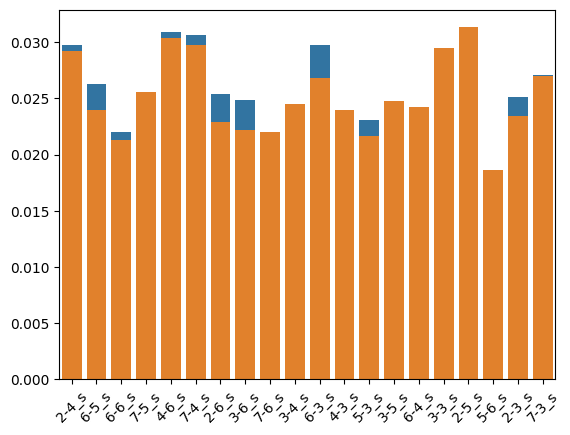

In [685]:
sns.barplot(x=order_f[0], y=[np.asarray(i).mean() for i in errors_storage_f.values()])
sns.barplot(x=order_fg[0], y=[np.asarray(i).mean() for i in errors_storage_fg.values()])
plt.xticks(rotation=45)

In [686]:
import re


def sector_graph_cell_fit(
    features,
    df,
    random_walk: bool = True,
    drop_not_neigbours: bool = True,
    iter_times: int = 10,
    ret_order: bool = False,
    valid_set: bool = False
):
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    order_storage = []

    for _ in range(iter_times):
        selected_keys = []
        key_features = features.copy()
        # print(key_features)
        df_c = df.copy()

        index = 0
        if random_walk:
            index = random.randint(0, len(walk.copy())-1)
        walk_route = graphs.make_walk_route(walk[index])
        # print("walk route:", walk_route)
        investifated = []
        
        for i in walk_route:
            edges_top = graphs.graph[i]
            
            # print("parent node: ", i)
            # print("pairs: ", edges_top)
            
            edges_top = [i, *edges_top]
            for j in edges_top:
                if j in investifated:
                    continue

                new_edges = graphs.graph[j] # edges to node that is currently processing
                step_sel = key_features[key_features.index(j)]    
        
                y = df_c.loc[:, step_sel]
                investifated.append(j)
                
                if len(investifated) == 1:
                    X_raw = df_c.drop(
                        key_features,
                        axis=1
                    )
                else:

                    # INCORRECT -> all edges belongs to parent node
                    # edges_top mus update according to current node
                    # edges_top.remove(j) # remove currenly predicting col
                    
                    
                    investifated_edges = set(investifated).intersection(set(new_edges))
                    to_drop = list(
                        set(key_features).difference(investifated_edges)
                    )

                    if drop_not_neigbours:
                        to_drop_c = to_drop.copy()
                        for i in to_drop_c:
                            res, *_ = re.findall(r'\d*-\d*', i) 
                            for j in df_c.columns:
                                if res in j:
                                    if not j in to_drop:
                                        # print(f"adding {j}")
                                        to_drop.append(j)
                                    
                    
                    # print("to use in step:", investifated_edges)
                    
                    X_raw = df_c.drop(
                        to_drop,
                        axis=1
                    )

                
                
                selected_keys.append(step_sel)
                # key_features.remove(step_sel)
                
                # print("predicts:\n", j, "\n", "to_predict:\n", X_raw.columns, "\n", "investigated:\n", investifated, "\n")
            
                ct = ColumnTransformer(
                    [
                        ("", StandardScaler(), X_raw.columns)
                        # ("", StandardScaler(), persantage_cols),
                        # ("norm", Normalizer(), list(set(X_raw).difference(set(persantage_cols)) ))
                    ],
                    remainder="passthrough"
                ).set_output(transform="pandas")
                
                X = ct.fit_transform(X_raw)
                X_train, X_test,\
                y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                
                model = GradientBoostingRegressor().fit(X_train, y_train)
                
                scores_storage[step_sel].append(
                    model.score(X_test, y_test)    
                )
                y_pred = model.predict(X_test) 
                
                errors_storage[step_sel].append(
                    mean_absolute_error(
                        y_test,
                        y_pred
                    )    
                )

                
                # replace column by predicted values to use them as input data in the next step
                # df_c.loc[y_test_ts1_test.index, step_sel] = y_gbr_ts1_test
            edges_top.clear()        
        order_storage.append(selected_keys)

    if ret_order:
        return errors_storage, scores_storage, order_storage
        
    return errors_storage, scores_storage

In [687]:
errors_storage_fgs,  scores_storage_fgs, order_fgs = sector_graph_cell_fit(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    iter_times=10,
    drop_not_neigbours=False,
    ret_order=True
)

['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-

In [688]:
errors_storage_fgs, order_fgs, np.asarray(list(errors_storage_fgs.values())).mean()

(defaultdict(list,
             {'2-4_s': [0.029517916564445766,
               0.027872702031806466,
               0.027561481955977758,
               0.027801539450123036,
               0.027839273438953576,
               0.028060604366304764,
               0.02747935517797261,
               0.027802776236172742,
               0.02967824941158193,
               0.027825125150312293],
              '3-4_s': [0.022641993683384296,
               0.026474418653512723,
               0.026668874780861797,
               0.02634588086579659,
               0.02675489639314361,
               0.026244060170784355,
               0.026486541647738126,
               0.026504839242362816,
               0.022687571554497653,
               0.026535752168986102],
              '2-3_s': [0.021600634051499774,
               0.02413141326650491,
               0.023110618055925986,
               0.024260873944290797,
               0.02359176570760911,
               0.0246322114354459

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, '2-4_s'),
  Text(1, 0, '6-5_s'),
  Text(2, 0, '6-6_s'),
  Text(3, 0, '7-5_s'),
  Text(4, 0, '4-6_s'),
  Text(5, 0, '7-4_s'),
  Text(6, 0, '2-6_s'),
  Text(7, 0, '3-6_s'),
  Text(8, 0, '7-6_s'),
  Text(9, 0, '3-4_s'),
  Text(10, 0, '6-3_s'),
  Text(11, 0, '4-3_s'),
  Text(12, 0, '5-3_s'),
  Text(13, 0, '3-5_s'),
  Text(14, 0, '6-4_s'),
  Text(15, 0, '3-3_s'),
  Text(16, 0, '2-5_s'),
  Text(17, 0, '5-6_s'),
  Text(18, 0, '2-3_s'),
  Text(19, 0, '7-3_s')])

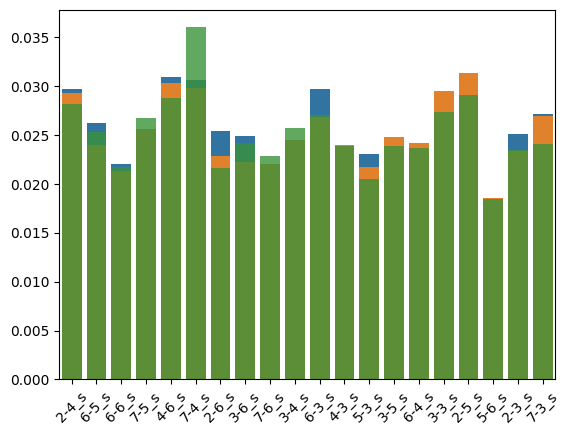

In [689]:
sns.barplot(x=order_f[0], y=[np.asarray(i).mean() for i in errors_storage_f.values()])
sns.barplot(x=order_fg[0], y=[np.asarray(i).mean() for i in errors_storage_fg.values()])
sns.barplot(x=order_fgs[0], y=[np.asarray(i).mean() for i in errors_storage_fgs.values()], alpha=0.8)
plt.xticks(rotation=45)

## From experience above:
### random walk approach helps to reduce MAE from 0.037 to 0.025
### random walk + graphs seems to be a bit robust 
### random walk + sector graphs method has shown much worse accuracy

## I have an idea to improve accuracy
### From random walk approach the errors vs cell distribution has obtained
### This distribution can be used to optimize leraning flow as follows:
#### use cell with lowest MAE as first cell to predict
#### use other cells to predict taking cells based on errors sorted in ascending order

In [690]:
def straight_cell_fit(
    features,
    df,
    iter_times: int = 10,
    ret_order: bool = False,
    valid_set: bool = False
):
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    order_storage = []

    # df = df.drop(features, axis=1)

    for _ in range(iter_times):
        selected_keys = []
        key_features = features.copy()

        df_c = df.copy()
        
        for n, i in enumerate(features):
        
            step_sel = i
            
            y = df_c.loc[:, step_sel]
            
            X_raw = df_c.drop(
                key_features,
                axis=1
            )
        
            # print("predicts:", step_sel, "to_predict:", X_raw.columns)
            
            selected_keys.append(step_sel)
            key_features.remove(step_sel)
        
            # print("selected:\n", selected_keys, "\n", "left:\n", key_features)
            
            ct = ColumnTransformer(
                [
                    ("", StandardScaler(), X_raw.columns)
                ]
            ).set_output(transform="pandas")
            
            X = ct.fit_transform(X_raw)
            X_train, X_test,\
            y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)
            
            model = GradientBoostingRegressor().fit(X_train, y_train)
            
            scores_storage[step_sel].append(
                model.score(X_test, y_test)    
            )
            y_pred = model.predict(X_test) 
            
            errors_storage[step_sel].append(
                mean_absolute_error(
                    y_test,
                    y_pred
                )    
            )

            # replace column by predicted values to use them as input data in the next step
            # df_c.loc[y_test_ts1_test.index, step_sel] = y_gbr_ts1_test
                
        order_storage.append(selected_keys)

    if ret_order:
        return errors_storage, scores_storage, order_storage
        
    return errors_storage, scores_storage

In [691]:
errors_storage_str,  scores_storage_str, order_str = straight_cell_fit(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    iter_times=10,
    ret_order=True
)

In [692]:
errors_storage_str, order_str, np.asarray(list(errors_storage_str.values())).mean()

(defaultdict(list,
             {'7-6_s': [0.03171502002621036,
               0.0316684184710064,
               0.031707824319391356,
               0.03165309761669599,
               0.03165982455328211,
               0.031848790908375835,
               0.03155109866077433,
               0.031912657497474406,
               0.03198515231708529,
               0.031508749549462374],
              '7-5_s': [0.024424859191895135,
               0.024890569266811675,
               0.024700732887043275,
               0.024503650989891403,
               0.024287917728388973,
               0.024663449328665682,
               0.02454907535414344,
               0.024529512665893927,
               0.02452706813794846,
               0.024758935369895145],
              '7-4_s': [0.02285469491410561,
               0.02279192758669266,
               0.02286313799872357,
               0.02317235872584877,
               0.02281364026028417,
               0.023130015654967948,
    

In [693]:
def independent_cell_fit(
    features,
    df,
    iter_times: int = 10,
    ret_order: bool = False,
    valid_set: bool = False
):
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    order_storage = []

    # df = df.drop(features, axis=1)

    for _ in range(iter_times):
        selected_keys = []
        key_features = features.copy()

        df_c = df.copy()
        
        for n, i in enumerate(features):
        
            step_sel = i
            
            y = df_c.loc[:, step_sel]
            
            X_raw = df_c.drop(
                key_features,
                axis=1
            )
        
            # print("predicts:", step_sel, "to_predict:", X_raw.columns)
            
            selected_keys.append(step_sel)
            # key_features.remove(step_sel)
        
            # print("selected:\n", selected_keys, "\n", "left:\n", key_features)
            
            ct = ColumnTransformer(
                [
                    ("", StandardScaler(), X_raw.columns)
                ]
            ).set_output(transform="pandas")
            
            X = ct.fit_transform(X_raw)
            X_train, X_test,\
            y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)
            
            model = GradientBoostingRegressor().fit(X_train, y_train)
            
            scores_storage[step_sel].append(
                model.score(X_test, y_test)    
            )
            y_pred = model.predict(X_test) 
            
            errors_storage[step_sel].append(
                mean_absolute_error(
                    y_test,
                    y_pred
                )    
            )

            # replace column by predicted values to use them as input data in the next step
            # df_c.loc[y_test_ts1_test.index, step_sel] = y_gbr_ts1_test
                
        order_storage.append(selected_keys)

    if ret_order:
        return errors_storage, scores_storage, order_storage
        
    return errors_storage, scores_storage

In [694]:
errors_storage_indep,  scores_storage_indep, order_indep = independent_cell_fit(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    iter_times=10,
    ret_order=True
)

In [695]:
errors_storage_indep, order_indep, np.asarray(list(errors_storage_indep.values())).mean()

(defaultdict(list,
             {'7-6_s': [0.03212867413270736,
               0.031783772680350965,
               0.03182260963461666,
               0.03153953283464115,
               0.031884706157887625,
               0.03160789420240854,
               0.03149369108638623,
               0.031312223563367936,
               0.031810522943513095,
               0.031446443875923255],
              '7-5_s': [0.023690085214342908,
               0.02406840259629178,
               0.024066182855202442,
               0.023662398454337385,
               0.02415755584774289,
               0.023913002203166927,
               0.024134363870734758,
               0.024173131941220227,
               0.02396408957602095,
               0.023856396711272786],
              '7-4_s': [0.029783630293019548,
               0.030286941583499427,
               0.030500351933414677,
               0.03019918796272064,
               0.03035055511074125,
               0.030587587124585293,


In [696]:
def ordered_cell_fit(
    features,
    df,
    order: list,
    iter_times: int = 10,
    ret_order: bool = False,
    valid_set: bool = False
):
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    order_storage = []

    # df = df.drop(features, axis=1)

    for _ in range(iter_times):
        selected_keys = []
        key_features = features.copy()

        df_c = df.copy()
        
        for i in range(len(features)):
        
            elem = order[i]
            step_sel = key_features[key_features.index(elem)]
            
            y = df_c.loc[:, step_sel]
            
            if i == -1:
                X_raw = df_c.drop(
                    key_features,
                    axis=1
                )
            else:
                to_drop = list(set(key_features).difference(set(selected_keys)))
                X_raw = df_c.drop(
                    to_drop,
                    axis=1
                )
        
            # print("predicts:", step_sel, "to_predict:", X_raw_ts1_test.columns)
            
            selected_keys.append(step_sel)
            key_features.remove(step_sel)
        
            # print("selected:\n", selected_keys, "\n", "left:\n", key_features)
            
            ct = ColumnTransformer(
                [
                    ("", StandardScaler(), X_raw.columns)
                ]
            ).set_output(transform="pandas")
            
            X = ct.fit_transform(X_raw)
            X_train, X_test,\
            y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
            
            model = GradientBoostingRegressor().fit(X_train, y_train)
            
            scores_storage[step_sel].append(
                model.score(X_test, y_test)    
            )
            y_pred = model.predict(X_test) 
            
            errors_storage[step_sel].append(
                mean_absolute_error(
                    y_test,
                    y_pred
                )    
            )

            # replace column by predicted values to use them as input data in the next step
            # df_c.loc[y_test_ts1_test.index, step_sel] = y_gbr_ts1_test
                
        order_storage.append(selected_keys)

    if ret_order:
        return errors_storage, scores_storage, order_storage
        
    return errors_storage, scores_storage

In [697]:
best_order = np.asarray(list(errors_storage_f.keys())) [ np.asarray([np.asarray(i).mean() for i in errors_storage_f.values()]).argsort() ]
print(best_order)

errors_storage_f_ordered,  scores_storage_f_ordered, order_f_ordered = ordered_cell_fit(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    order=best_order,
    iter_times=10,
    ret_order=True
)

['5-6_s' '7-6_s' '6-4_s' '3-4_s' '6-6_s' '4-3_s' '5-3_s' '3-5_s' '7-5_s'
 '3-6_s' '2-3_s' '2-6_s' '3-3_s' '6-5_s' '7-3_s' '2-5_s' '6-3_s' '2-4_s'
 '7-4_s' '4-6_s']


In [698]:
errors_storage_f_ordered, order_f_ordered, np.asarray(list(errors_storage_f_ordered.values())).mean()

(defaultdict(list,
             {'5-6_s': [0.016850419398448283,
               0.01676729118242757,
               0.01662740037053849,
               0.01662594728567403,
               0.016674133890311922,
               0.01703418191959669,
               0.01630017501713333,
               0.01707823382238721,
               0.016886640038325997,
               0.016440533723038737],
              '7-6_s': [0.0263321457135233,
               0.026352479222482315,
               0.0256562837871746,
               0.025778964454087082,
               0.026211846834506485,
               0.026305949976335716,
               0.0262683875100199,
               0.02630326577997621,
               0.026395334497328084,
               0.025836631852562054],
              '6-4_s': [0.02581525252601998,
               0.025888039824832714,
               0.0258851812991271,
               0.025830957513726764,
               0.02606387894282209,
               0.025733999402275085,
       

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, '2-4_s'),
  Text(1, 0, '6-5_s'),
  Text(2, 0, '6-6_s'),
  Text(3, 0, '7-5_s'),
  Text(4, 0, '4-6_s'),
  Text(5, 0, '7-4_s'),
  Text(6, 0, '2-6_s'),
  Text(7, 0, '3-6_s'),
  Text(8, 0, '7-6_s'),
  Text(9, 0, '3-4_s'),
  Text(10, 0, '6-3_s'),
  Text(11, 0, '4-3_s'),
  Text(12, 0, '5-3_s'),
  Text(13, 0, '3-5_s'),
  Text(14, 0, '6-4_s'),
  Text(15, 0, '3-3_s'),
  Text(16, 0, '2-5_s'),
  Text(17, 0, '5-6_s'),
  Text(18, 0, '2-3_s'),
  Text(19, 0, '7-3_s')])

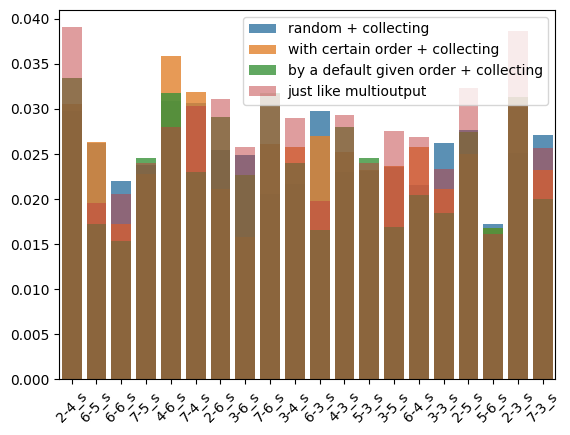

In [699]:
sns.barplot(x=order_f[0], y=[np.asarray(i).mean() for i in errors_storage_f.values()], alpha=0.8, label="random + collecting")
sns.barplot(x=order_f_ordered[0], y=[np.asarray(i).mean() for i in errors_storage_f_ordered.values()], alpha=0.8, label="with certain order + collecting")
sns.barplot(x=order_indep[0], y=[np.asarray(i).mean() for i in errors_storage_str.values()], alpha=0.8, label="by a default given order + collecting")
sns.barplot(x=order_str[0], y=[np.asarray(i).mean() for i in errors_storage_indep.values()], alpha=0.5, label="just like multioutput")
plt.xticks(rotation=45)

In [700]:
def graph_cell_fit_model_free(
    features,
    df,
    iter_times: int = 10,
    estimator: object | None = None,
    ret_order: bool = False,
    valid_set: bool = False
):
    if estimator is None:
        estimator = GradientBoostingRegressor()
        
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    order_storage = []

    for _ in range(iter_times):
        selected_keys = []
        key_features = features.copy()
        # print(key_features)
        df_c = df.copy()
        
        index = random.randint(0, len(walk.copy())-1)
        walk_route = graphs.make_walk_route(walk[index])
        # print("walk route:", walk_route)
        investifated = []
        
        for i in walk_route:
            edges = graphs.graph[i]
            for j in [i, *edges]:
                if j in investifated:
                    continue
                # print()
                step_sel = key_features[key_features.index(j)]    
        
                y = df_c.loc[:, step_sel]
                if len(investifated) == 0:
                    X_raw = df_c.drop(
                        key_features,
                        axis=1
                    )
                else:
                    to_drop = list(set(key_features).difference(set(selected_keys)))
                    X_raw = df_c.drop(
                        to_drop,
                        axis=1
                    )
                investifated.append(j)                
                selected_keys.append(step_sel)
                key_features.remove(step_sel)
                
                # print("predicts:\n", step_sel, "\n", "to_predict:\n", X_raw.columns, "\n", "investigated:\n", investifated, "\n")
            
                ct = ColumnTransformer(
                    [
                        ("", StandardScaler(), X_raw.columns)
                        # ("", StandardScaler(), persantage_cols),
                        # ("norm", Normalizer(), list(set(X_raw).difference(set(persantage_cols)) ))
                    ],
                    remainder="passthrough"
                ).set_output(transform="pandas")
                
                X = ct.fit_transform(X_raw)
                X_train, X_test,\
                y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=index)
                
                model = estimator.fit(X_train, y_train)
                
                scores_storage[step_sel].append(
                    model.score(X_test, y_test)    
                )
                y_pred = model.predict(X_test) 
                
                errors_storage[step_sel].append(
                    mean_absolute_error(
                        y_test,
                        y_pred
                    )    
                )
    
                # replace column by predicted values to use them as input data in the next step
                # df_c.loc[y_test_ts1_test.index, step_sel] = y_gbr_ts1_test
                    
        order_storage.append(selected_keys)

    if ret_order:
        return errors_storage, scores_storage, order_storage
        
    return errors_storage, scores_storage

In [701]:
errors_storage_fg_rigde,  scores_storage_fg_rigde, order_fg_rigde = graph_cell_fit_model_free(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    estimator=Ridge(),
    iter_times=10,
    ret_order=True
)

['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-

In [702]:
errors_storage_fg_rigde, order_fg_rigde, np.asarray(list(errors_storage_fg_rigde.values())).mean()

(defaultdict(list,
             {'4-6_s': [0.03649747559084078,
               0.029360914289695644,
               0.03215386976191463,
               0.033933554136415724,
               0.02835206787510913,
               0.033933554136415724,
               0.022618800661745746,
               0.023697621600741344,
               0.029360914289695644,
               0.030728199242743625],
              '5-6_s': [0.01335408344516961,
               0.013546901584418234,
               0.010180765466673422,
               0.011256093451666213,
               0.012983108957096036,
               0.011256093451666213,
               0.010531545913261421,
               0.009196856403918003,
               0.013546901584418234,
               0.011729937465476828],
              '3-6_s': [0.011461566359755421,
               0.008329702371783456,
               0.010193947498578847,
               0.009866409940799244,
               0.009232486195084504,
               0.00986640994079

In [703]:
np.asarray(d.CORE_PARTS["coef"]["ALL_CELLS"]), np.asarray(order_fg_rigde[4]).argsort(), order_fg_rigde[4]

(array(['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-6_s', '6-5_s', '6-4_s',
        '6-3_s', '5-6_s', '5-3_s', '4-6_s', '4-3_s', '3-6_s', '3-5_s',
        '3-4_s', '3-3_s', '2-6_s', '2-5_s', '2-4_s', '2-3_s'], dtype='<U5'),
 array([ 0,  2,  4,  6,  1,  3,  5,  7, 19,  8, 18,  9, 17, 15, 12, 10, 16,
        14, 13, 11]),
 ['2-3_s',
  '3-3_s',
  '2-4_s',
  '3-4_s',
  '2-5_s',
  '3-5_s',
  '2-6_s',
  '3-6_s',
  '4-6_s',
  '5-6_s',
  '6-6_s',
  '7-6_s',
  '6-5_s',
  '7-5_s',
  '7-4_s',
  '6-4_s',
  '7-3_s',
  '6-3_s',
  '5-3_s',
  '4-3_s'])

In [704]:
def straight_cell_fit_model_free(
    features,
    df,
    iter_times: int = 10,
    estimator: object | None = None,
    inpedendence: bool = None,
    ret_order: bool = False,
    valid_set: bool = False,
    ret_res: bool = False
):
    if estimator is None:
        estimator = GradientBoostingRegressor()
    
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    results = []
    order_storage = []

    # df = df.drop(features, axis=1)

    for _ in range(iter_times):
        selected_keys = []
        key_features = features.copy()

        df_c = df.copy()
        
        for n, i in enumerate(features):
        
            step_sel = i
            
            y = df_c.loc[:, step_sel]
            
            X_raw = df_c.drop(
                key_features,
                axis=1
            )
        
            # print("predicts:", step_sel, "to_predict:", X_raw.columns)
            
            selected_keys.append(step_sel)
            
            if not inpedendence:
                key_features.remove(step_sel)
        
            # print("selected:\n", selected_keys, "\n", "left:\n", key_features)
            
            ct = ColumnTransformer(
                [
                    ("", StandardScaler(), X_raw.columns)
                ]
            ).set_output(transform="pandas")
            
            X = ct.fit_transform(X_raw)
            X_train, X_test,\
            y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)
            model = estimator.fit(X_train, y_train)
            
            scores_storage[step_sel].append(
                model.score(X_test, y_test)    
            )
            y_pred = model.predict(X_test) 
            
            errors_storage[step_sel].append(
                mean_absolute_error(
                    y_test,
                    y_pred
                )    
            )

            # replace column by predicted values to use them as input data in the next step
            # df_c.loc[y_test_ts1_test.index, step_sel] = y_gbr_ts1_test
                
        order_storage.append(selected_keys)
        results.append(y_pred)

    if ret_order:
        return errors_storage, scores_storage, order_storage
        
    return errors_storage, scores_storage

In [705]:
errors_storage_str_rigde,  scores_storage_str_rigde, order_str_rigde = straight_cell_fit_model_free(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    estimator=Ridge(),
    iter_times=1,
    ret_order=True
)

In [710]:
errors_storage_str_rigde, order_str_rigde, np.asarray(list(errors_storage_str_rigde.values())).mean()

(defaultdict(list,
             {'7-6_s': [0.02488018711571603],
              '7-5_s': [0.01483278128343167],
              '7-4_s': [0.01204298303781734],
              '7-3_s': [0.012926691334519668],
              '6-6_s': [0.010307551298804262],
              '6-5_s': [0.011827732896506411],
              '6-4_s': [0.012527479266405359],
              '6-3_s': [0.01197565776257477],
              '5-6_s': [0.011162546218868568],
              '5-3_s': [0.01568548811756526],
              '4-6_s': [0.026679810340051974],
              '4-3_s': [0.015353326756606204],
              '3-6_s': [0.007231802739242631],
              '3-5_s': [0.008439538944623345],
              '3-4_s': [0.0094146495534888],
              '3-3_s': [0.009359024532742592],
              '2-6_s': [0.012659819066086792],
              '2-5_s': [0.01306541412009459],
              '2-4_s': [0.012991062017419118],
              '2-3_s': [0.011329268251740474]}),
 [['7-6_s',
   '7-5_s',
   '7-4_s',
   '7-3_s',

In [707]:
errors_storage_indep_rigde,  scores_storage_indep_rigde, order_indep_rigde = straight_cell_fit_model_free(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    estimator=Ridge(),
    inpedendence=True,
    iter_times=1,
    ret_order=True
)

In [708]:
errors_storage_indep_rigde, order_indep_rigde, np.asarray(list(errors_storage_indep_rigde.values())).mean()

(defaultdict(list,
             {'7-6_s': [0.02488018711571603],
              '7-5_s': [0.016187195761209673],
              '7-4_s': [0.01402165244201098],
              '7-3_s': [0.013148105975879709],
              '6-6_s': [0.010604226756239267],
              '6-5_s': [0.013764905013180083],
              '6-4_s': [0.014501337532373973],
              '6-3_s': [0.014456558317637666],
              '5-6_s': [0.01416780919929955],
              '5-3_s': [0.016583639457815113],
              '4-6_s': [0.033427722059877596],
              '4-3_s': [0.019356751782837966],
              '3-6_s': [0.006783189774045283],
              '3-5_s': [0.010372986649724972],
              '3-4_s': [0.014200993832187139],
              '3-3_s': [0.012023320895257565],
              '2-6_s': [0.015014735605015754],
              '2-5_s': [0.014981860083089087],
              '2-4_s': [0.014822818483946029],
              '2-3_s': [0.019057981090004065]}),
 [['7-6_s',
   '7-5_s',
   '7-4_s',
   '7-

Text(0.5, 0, 'Ячейка активной зоны')

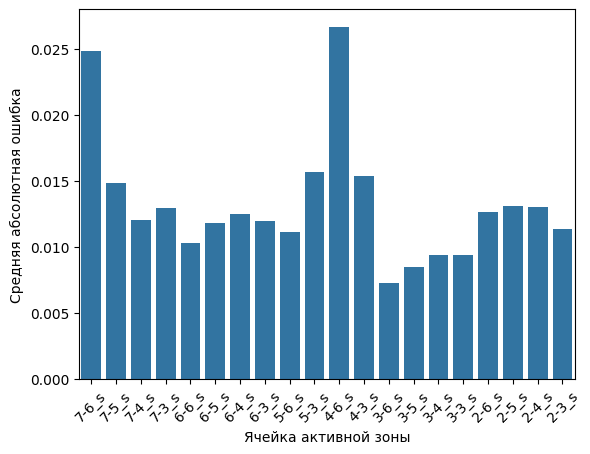

In [709]:
# sns.barplot(x=order_f[0], y=[np.asarray(i).mean() for i in errors_storage_f.values()], label="gbr + collecting")
# sns.barplot(x=order_fg[0], y=[np.asarray(i).mean() for i in errors_storage_fg.values()], label="gbr + graph + collecting")
# sns.barplot(x=order_fg_rigde[0], y=[np.asarray(i).mean() for i in errors_storage_fg_rigde.values()], alpha=1, label="ridge + graph + collecting")
sns.barplot(x=order_str_rigde[0], y=[np.asarray(i).mean() for i in errors_storage_str_rigde.values()], alpha=1) #label="ridge + by a default given order + collecting")
plt.xticks(rotation=45)
plt.ylabel("Средняя абсолютная ошибка")
plt.xlabel("Ячейка активной зоны")

## lets sum up what we've gotten for each cell by models
## I have made some optimizations like moves to check whether i can improve accuracy

In [310]:
esf_val = np.asarray(list(errors_storage_f.values())).mean(axis=1)
esf_key = np.asarray(list(errors_storage_f.keys()))
esf_sorted = esf_val.argsort()
for i in esf_sorted:
    print(f"key: {esf_key[i]}, val: {esf_val[i]}")

key: 5-6_s, val: 0.016750434086323825
key: 3-4_s, val: 0.01717675626418482
key: 7-3_s, val: 0.01740026971502948
key: 6-3_s, val: 0.022026904802603848
key: 2-6_s, val: 0.022063023030420553
key: 6-6_s, val: 0.023713329984058878
key: 6-4_s, val: 0.024059123765821845
key: 6-5_s, val: 0.02409452798102015
key: 3-3_s, val: 0.024697787527646873
key: 7-6_s, val: 0.02493714308426672
key: 7-4_s, val: 0.025395270198073833
key: 3-6_s, val: 0.025853609209975793
key: 5-3_s, val: 0.027706122407144713
key: 4-3_s, val: 0.027881214616216964
key: 7-5_s, val: 0.028637653162144422
key: 3-5_s, val: 0.02973061979992838
key: 2-4_s, val: 0.03161254315543115
key: 4-6_s, val: 0.03234933293672139
key: 2-5_s, val: 0.034562840788028085
key: 2-3_s, val: 0.03688122440745559


In [311]:
esfg_val = np.asarray(list(errors_storage_fg.values())).mean(axis=1)
esfg_key = np.asarray(list(errors_storage_fg.keys()))
esfg_sorted = esfg_val.argsort()
for i in esfg_sorted:
    print(f"key: {esfg_key[i]}, val: {esfg_val[i]}")

key: 3-4_s, val: 0.017174581079495474
key: 7-3_s, val: 0.017545624216385478
key: 2-6_s, val: 0.01789436886616074
key: 5-6_s, val: 0.01875170554462901
key: 6-3_s, val: 0.02011378652808107
key: 6-5_s, val: 0.021639640457162775
key: 6-4_s, val: 0.0247361386308114
key: 3-6_s, val: 0.024829346247807506
key: 6-6_s, val: 0.024923709426233023
key: 7-5_s, val: 0.025841903713119264
key: 7-4_s, val: 0.0265906072980228
key: 7-6_s, val: 0.026818166825622724
key: 3-3_s, val: 0.026854540306069024
key: 5-3_s, val: 0.02902086228439587
key: 4-3_s, val: 0.030640341906481773
key: 3-5_s, val: 0.03177468061510137
key: 4-6_s, val: 0.03242938948651468
key: 2-4_s, val: 0.0348869438424005
key: 2-5_s, val: 0.035514663875583156
key: 2-3_s, val: 0.036099874081857886


In [312]:
essr_val = np.asarray(list(errors_storage_str_rigde.values())).mean(axis=1)
essr_key = np.asarray(list(errors_storage_str_rigde.keys()))
essr_sorted = essr_val.argsort()
for i in essr_sorted:
    print(f"key: {essr_key[i]}, val: {essr_val[i]}")

key: 3-5_s, val: 0.008004524606814556
key: 3-4_s, val: 0.008630289061789012
key: 3-3_s, val: 0.00872423165721216
key: 5-6_s, val: 0.009313746897360113
key: 7-5_s, val: 0.00935221413821395
key: 2-4_s, val: 0.009659155406700683
key: 3-6_s, val: 0.011085226398879518
key: 2-5_s, val: 0.011909065023249902
key: 6-6_s, val: 0.012023492536426265
key: 6-3_s, val: 0.01216810644093479
key: 2-6_s, val: 0.012780706532292066
key: 6-4_s, val: 0.013681872966882466
key: 2-3_s, val: 0.013817533217739417
key: 7-4_s, val: 0.01638452098935792
key: 7-3_s, val: 0.018898981201061704
key: 5-3_s, val: 0.01984244696967761
key: 4-3_s, val: 0.019920161324595825
key: 7-6_s, val: 0.021794189462497962
key: 6-5_s, val: 0.02217265493731227
key: 4-6_s, val: 0.028056893906287024


In [313]:
def raw_cells_optimizer(
    features,
    df,
    iter_times: int = 10,
    estimator: object | None = None,
    ret_order: bool = False,
    valid_set: bool = False,
    ret_res: bool = False
):
    if estimator is None:
        estimator = GradientBoostingRegressor()
    
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    results = []
    order_storage = []

    # df = df.drop(features, axis=1)

    for _ in range(iter_times):
        selected_keys = []
        key_features = features.copy()

        df_c = df.copy()
        
        for n, i in enumerate(features):
        
            step_sel = i
                
            y = df_c.loc[:, step_sel]
            
            X_raw = df_c.drop(
                key_features,
                axis=1
            )
        
            # print("predicts:", step_sel, "to_predict:", X_raw.columns)
            
            selected_keys.append(step_sel)
            key_features.remove(step_sel)
        
            # print("selected:\n", selected_keys, "\n", "left:\n", key_features)
            
            ct = ColumnTransformer(
                [
                    ("", StandardScaler(), X_raw.columns)
                ]
            ).set_output(transform="pandas")

            X = ct.fit_transform(X_raw)
            X_train, X_test,\
            y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=n)
            
            if "6-3" in step_sel:
                model = GradientBoostingRegressor().fit(X_train, y_train)
            else:
                model = estimator.fit(X_train, y_train)
            
            scores_storage[step_sel].append(
                model.score(X_test, y_test)    
            )
            y_pred = model.predict(X_test) 
            
            errors_storage[step_sel].append(
                mean_absolute_error(
                    y_test,
                    y_pred
                )    
            )

            # replace column by predicted values to use them as input data in the next step
            # df_c.loc[y_test_ts1_test.index, step_sel] = y_gbr_ts1_test
                
        order_storage.append(selected_keys)
        results.append(y_pred)

    if ret_order:
        return errors_storage, scores_storage, order_storage
        
    return errors_storage, scores_storage

In [314]:
errors_storage_ridge_opt,  scores_storage_ridge_opt, order_rigde_opt = raw_cells_optimizer(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    estimator=Ridge(),
    iter_times=10,
    ret_order=True
)

In [315]:
errors_storage_ridge_opt, order_rigde_opt, np.asarray(list(errors_storage_ridge_opt.values())).mean()

(defaultdict(list,
             {'7-6_s': [0.021794189462497962,
               0.021794189462497962,
               0.021794189462497962,
               0.021794189462497962,
               0.021794189462497962,
               0.021794189462497962,
               0.021794189462497962,
               0.021794189462497962,
               0.021794189462497962,
               0.021794189462497962],
              '7-5_s': [0.00935221413821395,
               0.00935221413821395,
               0.00935221413821395,
               0.00935221413821395,
               0.00935221413821395,
               0.00935221413821395,
               0.00935221413821395,
               0.00935221413821395,
               0.00935221413821395,
               0.00935221413821395],
              '7-4_s': [0.01638452098935792,
               0.01638452098935792,
               0.01638452098935792,
               0.01638452098935792,
               0.01638452098935792,
               0.01638452098935792,
      

In [318]:
def graph_raw_cells_optimizer(
    features,
    df,
    iter_times: int = 10,
    estimator: object | None = None,
    ret_order: bool = False,
    valid_set: bool = False
):
    if estimator is None:
        estimator = GradientBoostingRegressor()
        
    scores_storage = defaultdict(list)
    errors_storage = defaultdict(list)
    order_storage = []

    for _ in range(iter_times):
        selected_keys = []
        key_features = features.copy()
        # print(key_features)
        df_c = df.copy()
        
        index = random.randint(0, len(walk.copy())-1)
        walk_route = graphs.make_walk_route(walk[index])
        # print("walk route:", walk_route)
        investifated = []
        
        for i in walk_route:
            edges = graphs.graph[i]
            for j in [i, *edges]:
                if j in investifated:
                    continue
                # print()
                step_sel = key_features[key_features.index(j)]    
        
                y = df_c.loc[:, step_sel]
                if len(investifated) == 0:
                    X_raw = df_c.drop(
                        key_features,
                        axis=1
                    )
                else:
                    to_drop = list(set(key_features).difference(set(selected_keys)))
                    X_raw = df_c.drop(
                        to_drop,
                        axis=1
                    )
                investifated.append(j)                
                selected_keys.append(step_sel)
                key_features.remove(step_sel)
                
                # print("predicts:\n", step_sel, "\n", "to_predict:\n", X_raw.columns, "\n", "investigated:\n", investifated, "\n")
            
                ct = ColumnTransformer(
                    [
                        # ("", StandardScaler(), X_raw.columns)
                        ("", StandardScaler(), percentage_cols),
                        # ("norm", Normalizer(), list(set(X_raw).difference(set(persantage_cols)) ))
                    ],
                    remainder="passthrough"
                ).set_output(transform="pandas")
                
                X = ct.fit_transform(X_raw)
                X_train, X_test,\
                y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=index)
                
                if "6-3" in step_sel or "7-6" in step_sel:
                    model = GradientBoostingRegressor().fit(X_train, y_train)
                else:
                    model = estimator.fit(X_train, y_train)
                
                scores_storage[step_sel].append(
                    model.score(X_test, y_test)    
                )
                y_pred = model.predict(X_test) 
                
                errors_storage[step_sel].append(
                    mean_absolute_error(
                        y_test,
                        y_pred
                    )    
                )
    
                # replace column by predicted values to use them as input data in the next step
                # df_c.loc[y_test_ts1_test.index, step_sel] = y_gbr_ts1_test
                    
        order_storage.append(selected_keys)

    if ret_order:
        return errors_storage, scores_storage, order_storage
        
    return errors_storage, scores_storage

In [319]:
errors_storage_g_ridge_opt,  scores_storage_g_ridge_opt, order_g_rigde_opt = graph_raw_cells_optimizer(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    estimator=Ridge(),
    iter_times=10,
    ret_order=True
)

['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-

In [320]:
errors_storage_g_ridge_opt, order_g_rigde_opt, np.asarray(list(errors_storage_g_ridge_opt.values())).mean()

(defaultdict(list,
             {'2-3_s': [0.014200383259787907,
               0.01502400856710324,
               0.016234719793994126,
               0.018601903785527427,
               0.014770697125775379,
               0.015144261211984448,
               0.015356798654094006,
               0.01502400856710324,
               0.014200383259787907,
               0.016007145383591857],
              '3-3_s': [0.015593139664368462,
               0.013759555131345302,
               0.011594416847008904,
               0.007809316744202583,
               0.013175646574603102,
               0.013967200892251844,
               0.010124297090022594,
               0.013759555131345302,
               0.015593139664368462,
               0.01148338182505617],
              '2-4_s': [0.010647750175670847,
               0.011253471530352806,
               0.013009147305540925,
               0.008323997460888416,
               0.010532457946702904,
               0.0091076752546

# Apllying Basic Stacking Technique

In [428]:
errors_storage_str_stck,  scores_storage_str_stck, order_str_stck = straight_cell_fit_model_free(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    estimator=StackingRegressor(
        [
            ("bgr", GradientBoostingRegressor()),
            ("bridge", BayesianRidge()),
            ("ridge", Ridge())
        ]
    ),
    iter_times=10,
    ret_order=True
)

In [429]:
errors_storage_str_stck, order_str_stck, np.asarray(list(errors_storage_str_stck.values())).mean()

(defaultdict(list,
             {'7-6_s': [0.019786242807140253,
               0.01960025648626854,
               0.019760291768167605,
               0.01964061878927814,
               0.019661791762526824,
               0.019646440482115533,
               0.019628258952104828,
               0.01971404251404644,
               0.01966843465537513,
               0.019725100327735598],
              '7-5_s': [0.013768724809375072,
               0.013519040832641271,
               0.013644317743442632,
               0.013705368033980007,
               0.013680290032300141,
               0.01368344985633982,
               0.01372183670566408,
               0.013455575114185159,
               0.013428631175428363,
               0.013399908949816342],
              '7-4_s': [0.012992949178729335,
               0.012944048455825051,
               0.012843263537123329,
               0.012823865841140087,
               0.01273861803126128,
               0.01300582798417954

In [424]:
errors_storage_g_stck,  scores_storage_g_stck, order_g_stck = graph_cell_fit_model_free(
    display.Display().CORE_PARTS["coef"]["ALL_CELLS"].copy(),
    df_ts_test,
    estimator=StackingRegressor(
        [
            ("bgr", GradientBoostingRegressor()),
            ("bridge", BayesianRidge()),
            ("ridge", Ridge()),
        ]
    ),
    iter_times=10,
    ret_order=True
)

['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-6_s', '6-6_s']
['7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-3_s', '5-3_s', '4-3_s', '3-3_s', '2-3_s', '2-4_s', '2-5_s', '2-6_s', '3-6_s', '4-6_s', '5-

In [425]:
errors_storage_g_stck, order_g_stck, np.asarray(list(errors_storage_g_stck.values())).mean()

(defaultdict(list,
             {'3-3_s': [0.020641817507114777,
               0.011015096513392537,
               0.015101180621212377,
               0.010895408574530075,
               0.004771069636874393,
               0.006957954659271429,
               0.007948458554500826,
               0.007264973875281925,
               0.009287779692941893,
               0.010346268520998252],
              '3-4_s': [0.01556456704642621,
               0.01089377203574869,
               0.008616454305305303,
               0.010877597926535164,
               0.017873428569123665,
               0.010246434607836667,
               0.009102496316196211,
               0.013417954139961451,
               0.010473802615724831,
               0.010483719034587195],
              '4-3_s': [0.01619497630911626,
               0.018335551933622875,
               0.008555137069251635,
               0.01833305506340604,
               0.010503466241083887,
               0.01853263306387